# Introduction

Our goal in this exercise is to build a program that captures short-term viewing preferences of customers based on their viewing history and build a content-based movie recommender. To that extent, we shall be utilizing the [MovieLens 25M data set](https://grouplens.org/datasets/movielens/25m/). This dataset consists of user-generated tags for roughly 45000 movies. We shall use these tags to create a database for our content-based recommender system. In this file, we shall pre-process the available data to desired format. To start, we shall load the necessary libraries. 

In [2]:
import pandas as pd
import os

In [3]:
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 99

We shall now load the 'tags.csv' file as a pandas dataframe that contains the tag data for the movies. We drop unnecessary columns such as 'timestamp' and 'userId'. Any entries that have '#NA' for tags are replaced with empty spaces. The final dataframe consists of the index column, the 'moviedId' column (which is a unique identifier for a movie) and the 'tag' column. Each entry in the 'tag' column corresponds to a single user-generated tag for the movie specified by the corresponding 'movieId' 

In [57]:
cwd = os.getcwd()
tags = pd.read_csv(os.path.join(cwd, "tags.csv"))
tags.drop(['timestamp','userId'], axis= 1, inplace= True)   #dropping the timestamp and userId columns since they are irrelevant to this analysis
tags.fillna("", inplace=True)   #searches for tags marked #NA and replaces them with empty spaces
tags.head()

,movieId,tag
0,260,classic
1,260,sci-fi
2,1732,dark comedy
3,1732,great dialogue
4,7569,so bad it's good


For a given, we shall now concatenate every user-generated tag to generate a "master tag". 

In [58]:
tags = pd.DataFrame(tags.groupby('movieId')['tag'].apply(lambda x: "%s" % ' '.join(x))) #concatenating all the tags for a given movie 
tags.reset_index(inplace=True)
tags.head()

,movieId,tag
0,1,Owned imdb top 250 Pixar Pixar time travel children comedy funny witty rated-G animation Pixar ...
1,2,Robin Williams time travel fantasy based on children's book board game disappearance giant inse...
2,3,funny best friend duringcreditsstinger fishing old man sequel fever moldy old sequel NO_FA_GANE...
3,4,based on novel or book chick flick divorce interracial relationship single mother CLV chick fli...
4,5,aging baby confidence contraception daughter gynecologist midlife crisis parent child relations...


Now, we shall load the 'movies.csv' file, which not only contains the movieId-title mapping but also the genre(s) that each movie corresponds to.

In [59]:
movies = pd.read_csv(os.path.join(cwd, "movies.csv"))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


We now remove every instance of "|" character from the 'genres' column and replace it with an empty space. If there is no genre listed ('(no genres listed)') we replace that with an empty space as well. We merge the 'tags' and 'movies' dataframe on the movieId column to get one big file that contains all the necessary information for each movie. Finally, we concatenate the genre information with the master-tag that was previously generated to get the 'document' corresponding to each movie.   

In [60]:
movies['genres'] = movies['genres'].str.replace(pat='|', repl = ' ', regex = False) #replace all the vertical separators with an empty space
movies['genres'] = movies['genres'].str.replace(pat='(no genres listed)', repl = ' ', regex = False) #regex = False treats () as a part of the string
tags = pd.merge(tags, movies, how='left',on='movieId')
tags['document'] = tags[['tag','genres']].apply(lambda x: ' '.join(x), axis= 1) #concatenate the master tag with the genre(s) of th movie
tags.head()

,movieId,tag,title,genres,document
0,1,Owned imdb top 250 Pixar Pixar time travel children comedy funny witty rated-G animation Pixar ...,Toy Story (1995),Adventure Animation Children Comedy Fantasy,Owned imdb top 250 Pixar Pixar time travel children comedy funny witty rated-G animation Pixar ...
1,2,Robin Williams time travel fantasy based on children's book board game disappearance giant inse...,Jumanji (1995),Adventure Children Fantasy,Robin Williams time travel fantasy based on children's book board game disappearance giant inse...
2,3,funny best friend duringcreditsstinger fishing old man sequel fever moldy old sequel NO_FA_GANE...,Grumpier Old Men (1995),Comedy Romance,funny best friend duringcreditsstinger fishing old man sequel fever moldy old sequel NO_FA_GANE...
3,4,based on novel or book chick flick divorce interracial relationship single mother CLV chick fli...,Waiting to Exhale (1995),Comedy Drama Romance,based on novel or book chick flick divorce interracial relationship single mother CLV chick fli...
4,5,aging baby confidence contraception daughter gynecologist midlife crisis parent child relations...,Father of the Bride Part II (1995),Comedy,aging baby confidence contraception daughter gynecologist midlife crisis parent child relations...


## Exploratory Data Analysis

We shall now perform some exploratory data analysis on the 'document' for each movie. Ideally, the longer the document is, the more descriptive the tags for the movie. This improves the quality of the recommendation scheme. 

In [92]:
tags['length'] = tags['document'].str.split().str.len()
tags['length'].describe()

count    45251.000000
mean        40.087313
std        168.862583
min          1.000000
25%          5.000000
50%          9.000000
75%         22.000000
max      10581.000000
Name: length, dtype: float64

As one can see, the average length of the document for a given movie is roughly 40 with a standard deviation of roughly 170. The histogram for the length of the tag document is below:

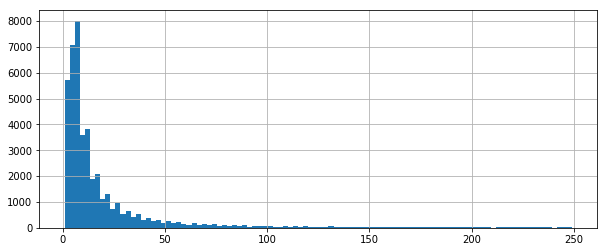

In [91]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
tags[tags['length']<250]['length'].hist(bins = 100)

We shall save the 'tags.csv' file to the database for use in our subsequent programs. Since the only information we need is the 'title' and the associated 'document' for each movie, we shall only write those columsn to disk. 

In [93]:
tags.to_csv(os.path.join(cwd, "tags_with_document.csv"), index=True, columns=['title', 'document'])

## TF-IDF and PCA 

We shall now use the tags dataframe and calculate the TF-IDF matrix for each tag for each movie in the dataframe

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(0,1), min_df = 0.0001, stop_words = 'english')
tfidf_matrix = tfidf.fit_transform(tags['document'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(),index=tags.index.tolist())

On the TF-IDF matrix, we perform PCA and extract the principal components specified by the 'n_components' parameter.

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 100)
principalComponents = pca.fit_transform(tfidf_df)
principalComponents_df = pd.DataFrame(data=principalComponents, index=tags.index.tolist())
principalComponents_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,-0.053902,0.001941,-0.090299,0.038624,-0.091975,0.213907,-0.005662,-0.176704,-0.002587,0.001484,-0.142637,-0.129378,-0.079494,-0.017493,-0.014489,0.040153,0.011690,-0.003693,0.014501,-0.024711,-0.009824,-0.031215,-0.005845,0.061342,-0.065543,0.167333,-0.030967,0.099270,-0.008975,-0.004888,-0.007209,-0.001276,-0.002771,-0.009082,0.023750,-0.006990,0.018457,-0.011696,-0.039804,0.026328,-0.014367,0.005035,-0.017158,0.056245,-0.005651,-0.020356,-0.021949,-0.039284,0.049473,-0.016801,-0.031101,0.006932,0.008910,0.002144,-0.018483,-0.007858,0.011993,0.002059,0.001211,-0.007887,-0.007231,0.003700,0.023267,-0.010695,0.004687,-0.002955,0.062308,0.036737,0.015335,0.046287,-0.101307,-0.029500,-0.014088,0.061901,0.027830,-0.004463,0.022337,-0.044968,0.011833,-0.029260,-0.025365,-0.023374,0.046374,-0.015766,0.018227,-0.042442,0.079704,0.012686,0.021050,0.020427,0.016323,-0.027058,0.006730,0.016786,0.021844,0.017080,-0.100367,0.004035,-0.020593,-0.047996
1,-0.050437,-0.039635,-0.048211,0.027431,-0.056871,0.087030,-0.011774,-0.029512,-0.011044,0.009921,0.003061,-0.008970,0.038399,0.022336,0.030095,-0.044842,0.091754,-0.025838,-0.016673,-0.016510,0.037360,0.023444,0.004373,-0.035546,0.072766,-0.066622,-0.025599,0.041411,0.064440,-0.048026,0.009657,-0.007437,-0.013896,-0.010533,-0.003791,-0.004436,-0.001063,-0.011269,-0.039871,-0.040291,-0.003423,-0.030859,-0.031352,0.027622,0.028270,-0.037720,-0.060461,-0.178452,0.129734,-0.144414,-0.064998,0.050289,0.008602,0.057543,-0.011843,-0.000872,0.045344,-0.010571,-0.009546,-0.012331,-0.002892,0.008091,0.009580,0.003001,0.008459,-0.049509,0.008132,0.012325,-0.022772,0.026125,-0.022907,-0.009287,0.004424,-0.015102,-0.010199,-0.016430,-0.011126,0.011807,0.013755,0.019768,-0.003487,-0.027013,0.028381,-0.013810,-0.005231,0.022792,0.055033,-0.007347,0.015634,-0.030678,0.007411,0.035290,-0.002791,0.024786,-0.007832,-0.011894,-0.040795,-0.008895,0.003064,-0.014368
2,-0.041464,0.014659,-0.032051,-0.002705,-0.028249,0.010320,-0.025370,0.015745,-0.023086,-0.022280,0.033749,-0.022710,0.009204,-0.025818,-0.007562,-0.044778,-0.011159,-0.016537,-0.007120,0.002046,-0.006882,-0.002809,-0.015247,-0.007969,-0.000763,0.003282,-0.033571,-0.000406,-0.006631,-0.009227,-0.005125,-0.004613,0.006323,-0.014854,-0.026319,0.003236,-0.000689,-0.015271,-0.020315,0.001914,-0.002677,-0.020571,-0.011827,-0.011501,0.010260,-0.011903,-0.002968,-0.003624,0.015819,0.032520,-0.025983,-0.004095,-0.005513,0.009507,-0.000491,0.011136,-0.026169,-0.011180,0.003128,-0.004680,-0.018192,-0.014253,0.007382,-0.034187,0.008367,-0.033166,0.033285,0.029822,-0.047761,0.039068,-0.114823,0.009154,-0.004359,-0.085977,0.032967,0.015362,-0.025861,0.051928,-0.026686,-0.070991,-0.001434,0.025959,-0.035387,0.072803,-0.039229,0.030081,0.000608,0.028602,-0.010581,0.027090,-0.064520,-0.021177,0.037496,-0.004235,0.030692,-0.000638,-0.009537,-0.038880,-0.017085,-0.008681
3,-0.032691,0.040974,0.027383,-0.034920,-0.058024,0.011567,-0.051395,0.014621,-0.042757,0.004052,0.020910,-0.024360,0.129875,0.104644,0.002600,-0.005804,-0.049044,0.003106,0.015288,-0.001349,-0.019075,-0.009135,0.011060,0.003346,-0.011114,-0.012204,-0.008672,0.001047,-0.013853,0.005632,-0.018446,-0.006002,-0.078827,-0.010645,0.038348,0.012390,0.006461,-0.003369,0.024467,0.000317,0.032422,-0.034550,-0.008726,-0.024176,-0.032081,0.028744,0.012935,-0.008162,0.055549,0.015600,0.057232,-0.053401,0.004121,0.006848,0.021860,-0.041998,-0.003663,-0.037851,0.015077,0.005554,-0.003728,0.004438,0.020108,-0.004280,-0.020149,0.002956,0.018057,0.010858,-0.015764,0.013348,-0.000903,0.007788,-0.000851,0.011320,-0.000264,-0.013457,-0.025545,0.004105,0.031550,-0.011877,-0.030832,0.022073,0.017322,-0.014236,-0.019626,-0.035323,-0.

We shall save this dataframe as a .csv file for further perusal in our exercise.

In [11]:
principalComponents_df.to_csv(os.path.join(cwd, "principal_Components.csv"), index=True)